Adam Peetz<br>
MSDS650 Week 3 Assignment<br>
Regis University<br>

# Bike Store Database

The Bike Store Database is a collection of 4 .csv files uploaded to Kaggle by Rohit Sahoo on September 11th, 2020. The files in the data set contain information on transactions, customer addresses, and customer demographic information for a bike store in Australia. A link to the dataset can be found in the references cell at the end of this report.<br>

I have a personal passion for bikes and bike retail. I developed this attraction when I worked for Vail Resort's Retail division. I am drawn to this dataset as an opportunity to explore bike retail data. Unfortunately, no supporting information exists on Kaggle to certify if this is a real or hypothetical dataset.<br>

Our exploration into the dataset will focus on the demographics of bike customers. The demographics information includes the job title and job industry information for 3/4 of the customers in the database. The goal is to understand what type of customer (by industry) is the most profitable. In addition to this, we will explore which brands are the most profitable.


In [1]:
#import libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt
import string
import random
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder 
%matplotlib inline

# Data Cleaning:
<b>1) Load and Merge Dataframes</b><br>
The analysis will combine features of the transactions and customer demographic database. To effectively perfrom the analysis, these two databases have to be joined using the pandas merge function into a single dataframe.<br>
Last name is also imputed here to populate missing last names before the data frames are joined. The code used to impute last name will be expanded upon during the impute missing values portion of this notebook<br>


In [25]:
#load data into dataframes from .csv source
transactions_df = pd.read_csv('archive/Transactions.csv', low_memory=False)
customer_df = pd.read_csv('archive/Customer Demographic.csv', low_memory=False)

# impute missing last names
# https://stackoverflow.com/questions/2257441/random-string-generation-with-upper-case-letters-and-digits

def lastname_generator(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))

def filllastnames(row):
    if pd.isnull(row.last_name):
        lastname = lastname_generator(5, "BIGLASTNAME")
        
    else:
        lastname = row.last_name
        
    return lastname

#apply last name generator
customer_df.last_name = customer_df.apply(lambda x: filllastnames(x), axis = 1)

#set index for each dataframe
transactions_df = transactions_df.set_index('transaction_id')
customer_df = customer_df.set_index('customer_id')

<b>2) Feature Selection: Reduction of Dimensionality</b><br>
Dimension reduction is the practice of dropping unnecessary information from the dataset. The advantages of dimension reduction are:
- less space to store the dataset
- faster calculations
- better performance of machine learning models.<br>
<br>
To reduce the dimensionality of the newly created dataframe, columns that do not relate to our objective of assessing customer demographics are dropped. The columns that do not relate to our objective are: 'product_first_sold_date','online_order','transaction_date','order_status', 'default','deceased_indicator', and 'past_3_years_bike_related_purchases'. <br>
<br>


In [3]:
#drop unneeded columns
transactions_df.drop(['product_first_sold_date','online_order','transaction_date','order_status'],axis=1,inplace=True)
customer_df.drop(['default','deceased_indicator','past_3_years_bike_related_purchases'],axis=1,inplace=True)

#merge transaction and customer dataframes
bikestore_df = pd.merge(transactions_df,customer_df, on='customer_id')

<b>3) Drop Null Values</b><br>
The focus of our exploration is into the demographics of each customer, primarily focused on their job industry. Unfortunately, job information was not supplied by 16% of the customers in the database. When joined to the transaction dataset, this leaves around 6000 rows or 28% of the data without a industry of job title. <br>

Shown below in a correlation graph, the industry and job title for each customer has no relation to any other variable in the dataset. To avoid skewing the data by randomly imputing 28% of its key values, rows missing these two key fields are dropped from the dataset. <br>

Finally, any rows with customers who did not enter dates of birth are dropped. Dates of birth are missing from around 3% of the customer profiles and cannot be imputed.<br>

In [4]:
#drop na values
bikestore_df.dropna(subset=['job_title'], inplace=True)
bikestore_df.dropna(subset=['job_industry_category'], inplace=True)

#reformat DOB to datetime format, datetime formata
bikestore_df['DOB'] = pd.to_datetime(bikestore_df['DOB'], errors='coerce',format= '%m/%d/%Y')
bikestore_df.dropna(subset=['DOB'], inplace=True)

<b>4)Imputing Missing Values.</b><br>
Next, missing standard cost values are imputed. This value is missing in around 100 rows, or 1% of the data. Retail margins are usually set at 50% of the cost of sale. To impute the missing cost, a formula of list price/2 will be applied across all null values to fill the cells.<br>

Brand is also missing from 1% of the data. There are 6 brands in the database. Each has a proportion between 14% and 21%. There is no way to determine brand from any other field so it will be filled randomly using a random number generator that rolls and assigns a brand based on the proportions of the brands in the database.<br>

Product_line, product_class, and product_size need to be imputed for the same rows. Each of these fields are skewed towards one category. <br>

- For product line, 'standard' makes up 71% of the data.
- For product_class, 'medium' makes up 69% of the data.
- For product_size, 'medium' makes up 65% of the data.<br>

The category comprising the majority of each field is imputed into the missing rows. 
<br>
The final column that has missing values was the last names column. Last names are semi-unique identifiers that are assigned at random to each person. Last names have been generatef for each customer using a random "name" generator before the customer dataframe is joined to the transactions database<br>


In [5]:
#impute missing standard price
def fillstandard_cost(row):
    if pd.isnull(row.standard_cost):
        price = row.list_price/2
        
    else:
        price = row.standard_cost
        
    return price

#apply standard price
bikestore_df.standard_cost = bikestore_df.apply(lambda x: fillstandard_cost(x), axis = 1)

#impute missing brand
#Random roll generator
#set seed so results can be reproduced
random.seed(1)

#create random roll function
def rollhundred(x=1):
    roll = random.randint(1,100)
    return roll

#fill brands based on random roll
def fillbrand(row):
    if pd.isnull(row.brand):
        choice = rollhundred()
        if choice <= 17:
            brand = 'Giant Bicycles'
        elif choice > 17 and choice <=31:
            brand = 'Norco Bicycles'
        elif choice > 31 and choice<=46:
            brand = 'OHM Cycles'
        elif choice > 46 and choice<=68:
            brand = 'Solex'
        elif choice > 68 and choice <= 83:
            brand = 'Trek Bicycles'
        elif choice > 83:
            brand = 'WeareA2B'            
    else:
         brand = row.brand
    return brand     

#apply fillbrand function
bikestore_df.brand = bikestore_df.apply(lambda x: fillbrand(x), axis = 1)

#product_line

#fill product_line
def fillproduct_line(row):
    if pd.isnull(row.product_line):
         product = 'standard'
    else:
         product = row.product_line
    return product

#product_line
bikestore_df.product_line = bikestore_df.apply(lambda x: fillproduct_line(x), axis = 1)

#product_class 
def fillproduct_class(row):
    if pd.isnull(row.product_class):
         product = 'medium'
    else:
         product = row.product_class
    return product

#product_class 
bikestore_df.product_class = bikestore_df.apply(lambda x: fillproduct_class(x), axis = 1)

#product_size 
def fillproduct_size(row):
    if pd.isnull(row.product_size):
         product = 'medium'
    else:
         product = row.product_size
    return product

#product_size 
bikestore_df.product_size = bikestore_df.apply(lambda x: fillproduct_size(x), axis = 1)

<b>5) Correct Formatting</b><br>
Gender should be a boolean variable. There are variations in the way female is indicated ("Femal", "F") in the database. This needs to be corrected to accurately divide the database by gender.<br>

Currency formatting "$" also needs to be removed from the standard_cost column. Currency formatting prevents the column from being treated like an integer or float variable in future calculations.


In [26]:
bikestore_df.gender.unique()

array([1, 0])

In [27]:
#correct gender formatting
bikestore_df['gender'] = bikestore_df['gender'].replace({"F":"F" , "Male":"M" ,"Female":"F","Femal":'F'})

#change currency format to float
bikestore_df["standard_cost"] = bikestore_df["standard_cost"].replace('[\$\,]',"",regex=True).astype(float)

<b>6)Outliers</b><br>
Boxplots can be used for a quick visual check of outliers. Values shown as bubbles outside the whiskers of the boxplot are considered to be outliers.<br>
A boxplot can be called for the entire dataframe to get a quick look at all the features. Any features with an outlier, like standard_cost, shown below, can be filtered for and examined in greater detail. <br>
Upon further investigation, these flagged "outliers" in the standard_cost column do not appear to be caused by any sort of mistake in the dataset. They are also not the result of a transformation we applied earlier in the code. As I cannot justify their removal, the values above 1700 in the standard_cost that were flagged as outliers will remain in the dataset. (Glenn, 2021)


<AxesSubplot:>

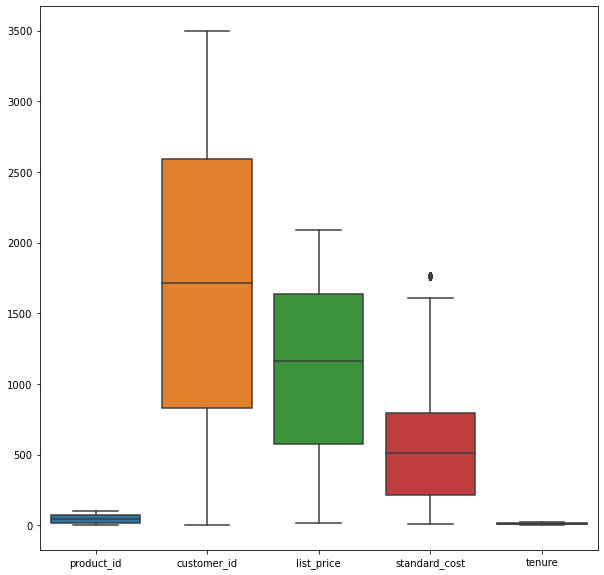

In [8]:
f = plt.figure(figsize=(10, 10))
sns.boxplot(data=bikestore_df)

<AxesSubplot:>

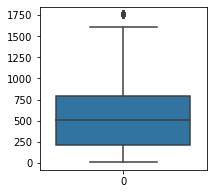

In [9]:
f = plt.figure(figsize=(3, 3))
sns.boxplot(data=bikestore_df['standard_cost'])

In [10]:
outlier_df = bikestore_df[bikestore_df['standard_cost'] > 1700]

In [11]:
outlier_df.head(5)

,product_id,customer_id,brand,product_line,product_class,product_size,list_price,standard_cost,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure
34,60,2339,Giant Bicycles,Standard,high,small,1977.36,1759.85,Damien,Haddeston,M,1958-12-28,Web Designer II,Property,Affluent Customer,Yes,16.0
189,60,2666,Giant Bicycles,Standard,high,small,1977.36,1759.85,Lyle,Eager,M,1971-02-16,Occupational Therapist,Health,Mass Customer,No,9.0
250,60,2916,Giant Bicycles,Standard,high,small,1977.36,1759.85,Lauren,Adolfson,M,1969-08-03,Product Engineer,Manufacturing,Affluent Customer,Yes,9.0
714,60,1076,Giant Bicycles,Standard,high,small,1977.36,1759.85,Siegfried,Trattles,M,2000-06-06,Pharmacist,Health,Affluent Customer,No,2.0
1193,60,1597,Giant Bicycles,Standard,high,small,1977.36,1759.85,Jeffry,Slowly,M,1977-02-01,Nurse Practicioner,Retail,Affluent Customer,No,14.0


### BONUS: FEATURE ENGINEERING:
AGE<br>
- As age is commonly used to segment markets. <br>
- Age is not in the dataset, but can be imputed using the customer’s date of birth, which is provided. <br>

AGE CLASSIFIER<br>
- Created to break the customers into buckets by age. For filtering and grouping operations. <br>

PROFIT<br>
- Profit has been imputed by taking the standard cost, which is the price of the item to the store, and subtracting it from the list price, which is the suggested price of sale to the customer by the manufacturer. <br>
- Profit will be used for value calculations as it is a better indicator of business performance than the sum of sales. <br>


In [12]:
# https://stackoverflow.com/questions/26788854/pandas-get-the-age-from-a-date-example-date-of-birth
# create age column
now = pd.Timestamp('now')
bikestore_df['DOB']= bikestore_df['DOB'].where(bikestore_df['DOB'] < now, bikestore_df['DOB'] -  np.timedelta64(100, 'Y'))   # 2
bikestore_df['age'] = (now - bikestore_df['DOB']).astype('<m8[Y]')    # 3

#age classifier function
def age_classifier(row):
    
    if row.age <= 19.9 :
        return 'Under 20'
    elif row.age  >= 20.0 and row.age < 29.99:
        return '20 - 30'
    elif row.age  >= 30.0 and row.age < 39.99:
        return '30 - 40'
    elif row.age  >= 40.0 and row.age < 49.99:
        return '40 - 50'
    elif row.age  >= 50.0 and row.age < 59.99:
        return '50 - 60'
    elif row.age  >= 60.0 and row.age < 69.99:
        return '60 - 70'
    elif row.age  >= 70.0:
        return 'Over 70'

#apply classifier to create age classifier column
bikestore_df['age_class'] = bikestore_df.apply(age_classifier, axis=1)

#subtract list price from standard cost to create profit.
bikestore_df['profit'] = bikestore_df['list_price'] - bikestore_df['standard_cost']

In [13]:
#sample df to see new features
bikestore_df.head()

,product_id,customer_id,brand,product_line,product_class,product_size,list_price,standard_cost,first_name,last_name,gender,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,age_class,profit
0,2,2950,Solex,Standard,medium,medium,71.49,53.62,Kristos,Anthony,M,1955-01-11,Software Engineer I,Financial Services,Mass Customer,Yes,10.0,66.0,60 - 70,17.87
1,1,2950,Giant Bicycles,Standard,medium,medium,1403.50,954.82,Kristos,Anthony,M,1955-01-11,Software Engineer I,Financial Services,Mass Customer,Yes,10.0,66.0,60 - 70,448.68
2,62,2950,Solex,Standard,medium,medium,478.16,298.72,Kristos,Anthony,M,1955-01-11,Software Engineer I,Financial Services,Mass Customer,Yes,10.0,66.0,60 - 70,179.44
3,3,3120,Trek Bicycles,Standard,medium,large,2091.47,388.92,Lauree,O'Donnell,F,1979-02-04,Clinical Specialist,Health,Mass Customer,Yes,10.0,42.0,40 - 50,1702.55
4,4,3120,Giant Bicycles,Standard,high,medium,1129.13,677.48,Lauree,O'Donnell,F,1979-02-04,Clinical Specialist,Health,Mass Customer,Yes,10.0,42.0,40 - 50,451.65


# Describe the data in your dataset
<b>Categorical vs Continuous variables</b><br>
The final dataset contains 5 continuous variables and 15 categorical ones.<br>
The continuous variables remaining in the data set are designed to measure the age of the customer and the value of their purchases. <br>
There categorical variables describe the type of customer and product they purchase.<br>
The final dataset after transformation is made up of 14451 transactions.<br>
A summary of columns and datatypes can be found in the table below.<br>

In [28]:
bikestore_df.shape

(14451, 20)

In [29]:
bikestore_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14451 entries, 0 to 19996
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   product_id             14451 non-null  int64         
 1   customer_id            14451 non-null  int64         
 2   brand                  14451 non-null  int32         
 3   product_line           14451 non-null  int32         
 4   product_class          14451 non-null  int32         
 5   product_size           14451 non-null  int32         
 6   list_price             14451 non-null  float64       
 7   standard_cost          14451 non-null  float64       
 8   first_name             14451 non-null  object        
 9   last_name              14451 non-null  object        
 10  gender                 14451 non-null  int32         
 11  DOB                    14451 non-null  datetime64[ns]
 12  job_title              14451 non-null  int32         
 13  j

# Statistical Summary

#### Feature Comparison Method #1 Univariate Analysis:
A quick statistical summary can be generated for the dataset using the pandas.describe function. This function performs a univariate analysis on the numerical fields in our dataset and returns standard indicators such as count, mean, mode, max, min, and standard deviation. A few valuable insights can be pulled from this summary about our key performance indicator: profit. <br><br>
<b>Profit Insights and Findings:</b>
- Average profit (mean) per sale is 552 dollars. <br>
- Lowest profit per sale is about 5 dollars.
- Maximum profit is 1702 dollars.

Some demographic information about the age of customers in the database also emerges here.<br><br>
<b>Demographic Insights and Findings:</b>
- Average age of a customer is 43.
- Youngest customer is 19.
- Oldest customer is 90.
- On average people have been customers for 10 years.




In [16]:
bikestore_df.describe().T

,count,mean,std,min,25%,50%,75%,max
product_id,14451.0,45.182133,30.659127,0.00,18.00,44.00,72.00,100.00
customer_id,14451.0,1715.631444,1012.432335,1.00,829.00,1714.00,2592.00,3497.00
list_price,14451.0,1111.283740,584.050426,12.01,575.27,1163.89,1635.30,2091.47
standard_cost,14451.0,559.096245,408.076423,7.21,215.14,507.58,795.10,1759.85
tenure,14451.0,10.716490,5.673172,1.00,6.00,11.00,16.00,22.00
age,14451.0,43.575254,12.574784,19.00,34.00,44.00,53.00,90.00
profit,14451.0,552.187495,492.163455,4.80,135.85,445.21,827.16,1702.55


# Graphical visualization of features 

When performing EDA. It is always a good idea to look at all features in the database before digging into specific metrics. A histogram can be called on an entire dataframe show the distribution of numerical fields in the dataset. This type of broad stroke analysis can sometimes drive unforeseen insights into the dataset. <br><br>
<b>Insights and Findings:</b>
- Standard cost is skewed left, towards lower costs in the dataset.
- Age has a massive spike around the age of 40.
- Tenure looks continuously distributed, with spike where you would expect them to be on both sides for lifelong and new customers. <br>
<br>
After performing this level of analysis. The data can be grouped and sliced to look for specific insights.



array([[<AxesSubplot:title={'center':'product_id'}>,
        <AxesSubplot:title={'center':'customer_id'}>,
        <AxesSubplot:title={'center':'list_price'}>],
       [<AxesSubplot:title={'center':'standard_cost'}>,
        <AxesSubplot:title={'center':'DOB'}>,
        <AxesSubplot:title={'center':'tenure'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'profit'}>, <AxesSubplot:>]],
      dtype=object)

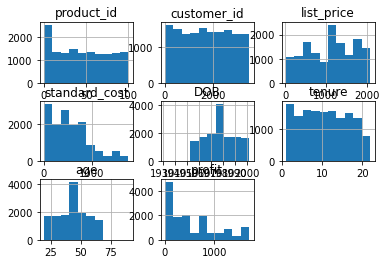

In [17]:
bikestore_df.hist()

# Most Avid and Profitable Customer (By Industry)
The first goal was to look at what type of customer was the best customer using demographic information in the dataset. Here we will focus on count of transactions and profits based on the type of industry the customer works in.<br>

<b>Insights and Findings</b><br>
- 3532 of our sales come from customers in the entertainment industry. This is closely followed by Retail. Our least interested group of workers comes from the telecommunications industry, making up only 315 sales in the database.
- To gauge profit by industry, a comparison of average profit for each segment of workers is used instead of the sum. A sum measure would be biased towards industries with a large count of sales. Using an average, we can look at which group is spending more without the count of sales bias. Our highest spender is still the entertainment induasty, however, agriculture, health, and IT come towards the top of the list. These groups are in the middle when judged by transaction count but happen to be buying products with better margins than workers in other industries.


In [18]:
#group by industry and count, sort for highest value
industrygraph = bikestore_df.groupby('job_industry_category').count()
industrygraph['industry'] = ['Financial Services', 'Health', 'Retail', 'Property',\
                               'Manufacturing', 'Entertainment', 'IT', 'Argiculture',\
                               'Telecommunications'\
                            ]

industrygraph.sort_values(by='product_id',inplace=True,ascending=False)

#group by industry and evaluate mean profit, sort for highest value
industrygraphtwo = bikestore_df.groupby('job_industry_category').mean()
industrygraphtwo['industry'] = ['Financial Services', 'Health', 'Retail', 'Property',\
                               'Manufacturing', 'Entertainment', 'IT', 'Argiculture',\
                               'Telecommunications'\
                            ]

industrygraphtwo.sort_values(by='profit',inplace=True,ascending=False)


Text(0.5, 1.0, 'Most Profitable Customer (by Industry)')

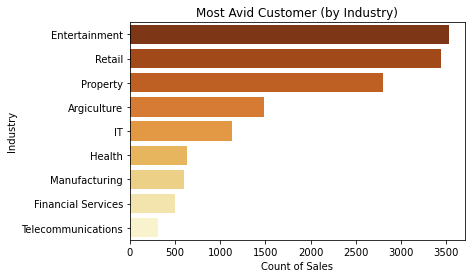

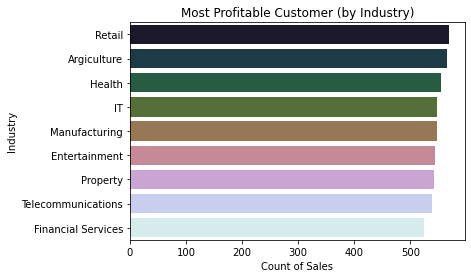

In [19]:
sns.barplot(data=industrygraph,x='product_id',y='industry',palette='YlOrBr_r')
plt.ylabel('Industry')
plt.xlabel('Count of Sales')
plt.title('Most Avid Customer (by Industry)')

plt.figure()
sns.barplot(data=industrygraphtwo,x='profit',y='industry',palette='cubehelix')
plt.ylabel('Industry')
plt.xlabel('Count of Sales')
plt.title('Most Profitable Customer (by Industry)')

# Most Popular Brand - Most Profitable Brand
The second goal was to determine the most profitable and most popular brand in the dataset.<br>

<br><b>Insights and Findings</b>
- The most popular brand, as determined by the count of transactions, is Solex, with 3,149 discrete transactions. The worst performing supplier is Norco Bicycles, which only sold 2,127 products, a difference of ~32%.<br>
- The most profitable brand, as determined by the sum of profits, is WeAre2B. WeAre2B accounts for 1,964,022 dollars in profit, outperforming the second most profitable brand Solex, by ~174,000 dollars, a difference of 9%.


In [20]:
#group by brand and count, sort for highest value
brandgraph = bikestore_df.groupby('brand').count()
brandgraph['brand'] = ['Giant Bicycles','Norco Bicycles','OHM Cycles','Solex','Trek Bicycles','WeareA2B']
brandgraph.sort_values(by='product_id',inplace=True,ascending=False)

#group by brand and sum sort for highest value
brandgraphtwo = bikestore_df.groupby('brand').sum()
brandgraphtwo['brand'] = ['Giant Bicycles','Norco Bicycles','OHM Cycles','Solex','Trek Bicycles','WeareA2B']
brandgraphtwo.sort_values(by='profit',inplace=True,ascending=False)

Text(0.5, 1.0, 'Most Profitable Brand')

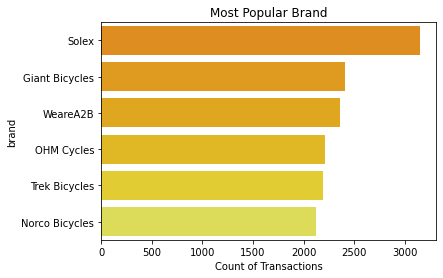

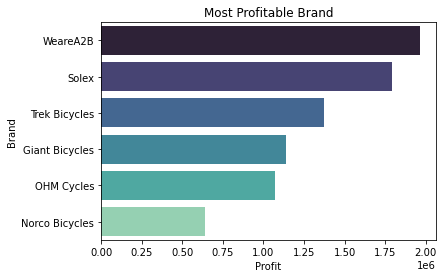

In [21]:
#create brand popularity chart
sns.barplot(data=brandgraph,x='product_id',y='brand',palette='Wistia_r')
plt.ylabel('brand')
plt.xlabel('Count of Transactions')
plt.title('Most Popular Brand')

#create profit chart
plt.figure()
sns.barplot(data=brandgraphtwo,x='profit',y='brand',palette='mako')
plt.ylabel('Brand')
plt.xlabel('Profit')
plt.title('Most Profitable Brand')

# Feature Comparison Method #2: Multivariate Correlation Heatmap

A correlation heatmap can be constructed to quickly review how all the variables in the dataset are interacting with each other. Correlation can only be gauged on fields when they contain numerical values. A label encoder can be applied to quickly convert categorical fields to numerical ones in the dataset. This quick trick allows all of the variables to be compared for correlation as shown below. The correlation map plotted here was created at the start of the project and referenced continuously to guide the analysis <br><br>

<b>Insights and Findings</b><br>

Correlated Variables:<br>
- Tenure and Customer Age
- List Price and Standard Cost
- Profit and List Price
- Profit and Brand, Product Line, Product Class

Non-related Variables:
- Any measure of demographics and profit. Correlation was highly desired here, but none is present in this dataset.


In [30]:
correlation_df = bikestore_df

In [31]:
#initializing an object of class LabelEncoder
labelencoder= LabelEncoder() 

#fit and transform desired columns
correlation_df['brand'] = labelencoder.fit_transform(correlation_df['brand'])
correlation_df['product_line'] = labelencoder.fit_transform(correlation_df['product_line']) 
correlation_df['product_size'] = labelencoder.fit_transform(correlation_df['product_size']) 
correlation_df['gender'] = labelencoder.fit_transform(correlation_df['gender']) 
correlation_df['job_title'] = labelencoder.fit_transform(correlation_df['job_title']) 
correlation_df['job_industry_category'] = labelencoder.fit_transform(correlation_df['job_industry_category']) 
correlation_df['wealth_segment'] = labelencoder.fit_transform(correlation_df['wealth_segment']) 
correlation_df['owns_car'] = labelencoder.fit_transform(correlation_df['owns_car']) 
correlation_df['product_class'] = labelencoder.fit_transform(correlation_df['product_class']) 

<AxesSubplot:>

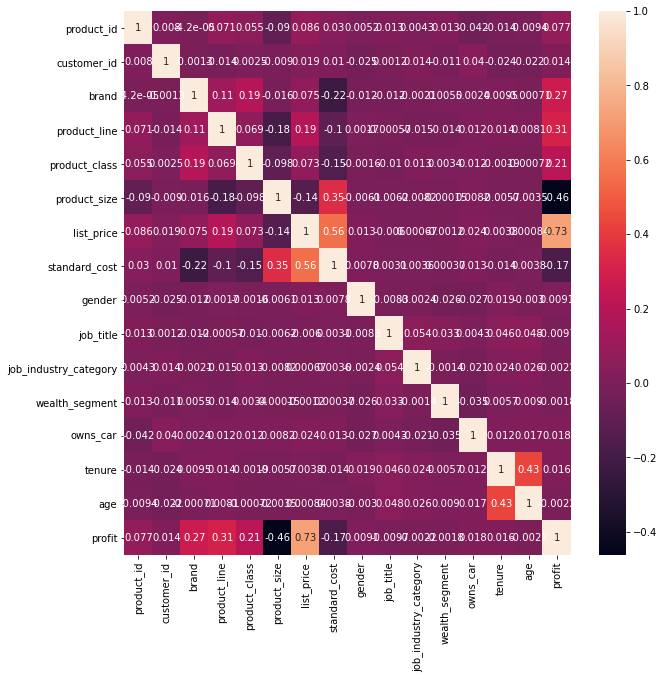

In [32]:
#plot correlation heatmap
f = plt.figure(figsize=(10, 10))
sns.heatmap(correlation_df.corr(), annot=True)

# References

Glen, Stephanie. 2021. <i>descriptive-statistics/box-plot</i> From StatisticsHowTo.com: Elementary Statistics for the rest of us! https://www.statisticshowto.com/contact/https://www.statisticshowto.com/probability-and-statistics/descriptive-statistics/box-plot/

Pandas Development Team. 2021. <i>Python API reference</i> from pandas.pydata.org https://pandas.pydata.org/docs/reference/index.html

Sahoo, Rohit. 2021. <i>Bike Store Database</i> from kaggle.come https://www.kaggle.com/rohitsahoo/bicycle-store-dataset

Username: ubuntu. November 6th 2014. <i>Pandas get the age from a date (example: date of birth)</i> from Stackoverflow.com https://stackoverflow.com/questions/26788854/pandas-get-the-age-from-a-date-example-date-of-birth

Username: Ignacio Vazquez-Abrams <i>random-string-generation-with-upper-case-letters-and-digits</i> from stackoverflow.com
https://stackoverflow.com/questions/2257441/random-string-generation-with-upper-case-letters-and-digits

